### MTA Data Challenge

In this project I used the MTA turstile dataset from http://web.mta.info/developers/turnstile.html. There were two different data formats used, one for data before 10/8/2014 and one for after. In my analysis, I named the dataset containing the old format old_data and the new format new_data. I created a function to iteratively read the online data and add it to a text file. At the end of the data scrapping phase there are two text files that were created, one for each type of format. 
After reading the data, I cleaned up the format of the old data to match the new one. Since there is a lot of data, processing this took quite some time. In hindsight, I should have created a sqlite database and manipulated the data there, and done some of analysis there. After some time, I realized that there was a bit too much data to try and combine both the new and old datasets into one pandas dataframe. Since I had already done most of the work in pandas at that point, I focused most of my analysis on the new data to reduce the volume.

In [1]:
import sys
import io
import os
import pandas as pd
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import LabelEncoder, scale

project_dir = '/Users/Gabi/dev/viacom/src/'
data_dir= '/Users/Gabi/dev/viacom/data/'


In [2]:
remote_mapping = pd.read_csv(data_dir + 'Remote-Booth-Station_2.csv', encoding='utf-8')

# dictionary for remote lookup
d = {
    'Station' :remote_mapping.groupby('Remote')['Station'].apply(lambda x: x.tolist().pop() if len(x)==1 else x.tolist()),
    'LineName' :remote_mapping.groupby('Remote')['LineName'].apply(lambda x: x.tolist().pop() if len(x)==1 else x.tolist())
}

# headers - these are different before 10/18/2014 and after
headers_old = ['ControlArea', 'UNIT', 'SCP', 'DATE1', 'TIME1', 'DESC1', 'ENTRIES1', 'EXITS1', 'DATE2', 'TIME2', 'DESC2',
          'ENTRIES2', 'EXITS2', 'DATE3', 'TIME3', 'DESC3', 'ENTRIES3', 'EXITS3', 'DATE4', 'TIME4', 'DESC4', 'ENTRIES4',
          'EXITS4', 'DATE5', 'TIME5', 'DESC5', 'ENTRIES5', 'EXITS5', 'DATE6', 'TIME6', 'DESC6', 'ENTRIES6', 'EXITS6',
          'DATE7', 'TIME7', 'DESC7', 'ENTRIES7', 'EXITS7', 'DATE8', 'TIME8', 'DESC8', 'ENTRIES8', 'EXITS8']
headers_new = ['ControlArea','UNIT','SCP','STATION','LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']


In [3]:
def combine_urls(date_range,out_file,mta_data_type):
    '''
    Function to write all text from urls into file
    :param date_range: pd.date_range object 
    :param out_file: path + name of file to write to
    :param mta_data_type: 'new' or 'old' to distinguish data 
                        before 10/18/2014 which was formatted differently
    :return: .txt file
    '''
    base_url = 'http://web.mta.info/developers/data/nyct/turnstile/'
    error_list = []
    for i in date_range:
        s = datetime.datetime.strftime(i, '%y%m%d')
        url = base_url + 'turnstile_' + s + '.txt'
        r = requests.get(url=url)
        if r.status_code==404:
            pass
        else:
            content = r.content.decode('utf-8')
            # new formatted data has header that needs to be removed
            if mta_data_type =='new':
                content_header = content.strip().split('\n')[0]
                content = content.strip(content_header)
                
            try:
                with open(out_file, 'a') as outfile:
                    outfile.write(content)
                    #print "wrote ", url, " content to file"
            except Exception as e:
                print "error" ,e
                error_list.append(i)
    return outfile

In [116]:
def clean_old_data(old_df, mapping_dict, headers_new):
    '''
    Function to reformat data before 10/18/2014 to match newest format
    
    :param old_df: DataFrame object with old data
    :param mapping_dict: dictionary to look up station info
    :param headers_new: headers to match new format
     returns: Formatted old data
    
    '''
    # fill null values in numeric columns (entries & exists)
    entries = old_df.columns[old_df.columns.str.contains('ENTRIES')]
    old_df[entries] = old_df[entries].fillna(0.0)
    exits = old_df.columns[old_df.columns.str.contains('EXITS')]
    old_df[exits] = old_df[exits].fillna(0.0)

    # create column of total entries and exists
    old_df['ENTRIES'] = old_df[entries].sum(axis=1)
    old_df['EXITS'] = old_df[exits].sum(axis=1)
    old_df = old_df.drop(entries + exits, axis=1)

    # combine DESC
    desc = old_df.columns[old_df.columns.str.contains('DESC')]
    temp = pd.melt(frame=old_df, value_name='DESC', value_vars= desc.values.tolist())
    old_df['DESC'] = temp['DESC']
    old_df = old_df.drop(desc, axis = 1)

    # combine DATE
    dates = old_df.columns[old_df.columns.str.contains('DATE')]
    temp = pd.melt(frame=old_df,value_name='DATE', value_vars=dates.values.tolist())
    old_df['DATE'] = temp['DATE']
    old_df = old_df.drop(dates, axis = 1)

    # combine TIME
    times = old_df.columns[old_df.columns.str.contains('TIME')]
    temp = pd.melt(frame=old_df,value_name='TIME', value_vars= times.values.tolist())
    old_df['TIME'] = temp['TIME']
    old_df = old_df.drop(times, axis = 1)

    old_df['UNIT'] = old_df['UNIT'].fillna('Unknown')
    # add in Station info
    old_df['STATION'] =  old_df.UNIT.map(lambda x: mapping_dict['Station'].get(x))
    # add in Line info
    old_df['LINENAME'] = old_df.UNIT.map(lambda x: mapping_dict['LineName'].get(x))
    # add in Division
    old_df['DIVISION'] = np.nan

    # reorder columns to match new format
    old_df = old_df[headers_new]

    return old_df

def remove_bad_date_rows(x):
    '''
        Function to remove rows where the date is in a bad format. This is used in the old data
        where a bad date indicates row doesnt contain clean data and row should be discarded
    '''
    try:
        x_new = datetime.datetime.strptime(x, '%m-%d-%y')
    except Exception as e:
        x_new = 'DROP'
    return x_new

### 1) Data Processing Cleaning
To start the data challenge, I created the *combine_urls* function to scrape MTA data and combine into a text file. 

The function has the following parameters: 
*date_range*: this is needed to be able to scrape MTA data in both the new and old formats
*out_file*: the name of the file to write to
*mta_data_type*: if data is in the new format then 'new' has to be specified, so that the header can be removed from each file.

Next, I change the format of the old data to match that of the new data. 
The old data from before 10/18/2014 was in a long format, so I used the melt function to reformat these columns into one. I did this for the DESC, DATE, and TIME columns. I combined all the ENTRIES into one column and EXITS also, and created the turnstile busyness metric. I added the Station and LineName columns based on the mapping file online.

In [ ]:
# write new data to a file
new_file= data_dir + "new_file_v3.txt"
outf_new = combine_urls(date_range=new_dates, out_file=new_file, mta_data_type = 'new')

In [5]:
new_file = data_dir + 'new_file_v3.txt'
new_data = pd.read_csv(filepath_or_buffer=new_file, names=headers_new, header=None, delimiter=',',
                       engine='c', encoding='utf-8', error_bad_lines=False, skiprows = [0], 
                       parse_dates=True, infer_datetime_format=True)
print "*" *50
print "Finished reading new data file with shape:", new_data.shape
print "*" *50

**************************************************
Finished reading new data file with shape: (27076462, 11)
**************************************************


In [6]:
# inspect data
new_data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A060,R001,00-00-00,WHITEHALL ST,R1,BMT,10/11/2014,01:00:00,REGULAR,805439.0,1141080.0
1,A060,R001,00-00-00,WHITEHALL ST,R1,BMT,10/11/2014,05:00:00,REGULAR,805459.0,1141141.0
2,A060,R001,00-00-00,WHITEHALL ST,R1,BMT,10/11/2014,09:00:00,REGULAR,805589.0,1141257.0
3,A060,R001,00-00-00,WHITEHALL ST,R1,BMT,10/11/2014,13:00:00,REGULAR,805834.0,1141512.0
4,A060,R001,00-00-00,WHITEHALL ST,R1,BMT,10/11/2014,17:00:00,REGULAR,806150.0,1141903.0


In [7]:
# look at datatypes
new_data.dtypes

ControlArea     object
UNIT            object
SCP             object
STATION         object
LINENAME        object
DIVISION        object
DATE            object
TIME            object
DESC            object
ENTRIES        float64
EXITS          float64
dtype: object

In [8]:
# drop Division - we don t have this information for old data
new_data = new_data.drop(['DIVISION'], axis=1)

In [ ]:
# write old data to a file
old_file = data_dir + 'old_file.txt'
outf_new = combine_urls(date_range=old_filed_dates, out_file=old_file, mta_data_type = 'old')

In [9]:
old_file = data_dir + 'old_file.txt'
old_data = pd.read_csv(filepath_or_buffer=old_file, names=headers_old, header=None, delimiter=',',
                       engine='c', encoding='utf-8', error_bad_lines=False, skiprows = [0], 
                       dtype={'DATE':np.datetime64})

print "*" *50
print "Finished reading old file with shape:", old_data.shape
print "*" *50

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**************************************************
Finished reading old file with shape: (5899719, 43)
**************************************************


In [10]:
# looks like there is quite some formating that needs to get done to get the old data in the same format as the new!
old_data.head()

,ControlArea,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,...,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8
0,A002,R051,02-00-00,01-02-11,11:00:00,REGULAR,2994794,1033818,01-02-11,15:00:00,...,01-03-11,11:00:00,REGULAR,2.99542e+06,1.03428e+06,01-03-11,15:00:00,REGULAR,2995634.0,1.03436e+06
1,A002,R051,02-00-00,01-03-11,19:00:00,REGULAR,2996441,1034426,01-03-11,23:00:00,...,01-04-11,19:00:00,REGULAR,2.99787e+06,1.03497e+06,01-04-11,23:00:00,REGULAR,2998176.0,1.03499e+06
2,A002,R051,02-00-00,01-05-11,03:00:00,REGULAR,2998197,1034992,01-05-11,07:00:00,...,01-06-11,03:00:00,REGULAR,2.9997e+06,1.03554e+06,01-06-11,07:00:00,REGULAR,2999713.0,1.03558e+06
3,A002,R051,02-00-00,01-06-11,11:00:00,REGULAR,2999856,1035815,01-06-11,13:32:32,...,01-07-11,07:00:00,REGULAR,3.00123e+06,1.03589e+06,01-07-11,09:06:36,DOOR,3001298.0,1.03612e+06
4,A002,R051,02-00-00,01-07-11,09:06:44,DOOR,3001298,1036119,01-07-11,09:08:15,...,01-07-11,23:00:00,REGULAR,3.00266e+06,1.03640e+06,NaN,NaN,NaN,NaN,NaN


In [11]:
# fill null values in numeric columns (entries & exists)
entries = old_data.columns[old_data.columns.str.contains('ENTRIES')]
old_data[entries] = old_data[entries].fillna(0.0)
exits = old_data.columns[old_data.columns.str.contains('EXITS')]
old_data[exits] = old_data[exits].fillna(0.0)


In [12]:
# create column of total entries and exists
old_data['ENTRIES'] = old_data[entries].sum(axis=1)
old_data['EXITS'] = old_data[exits].sum(axis=1)
old_data = old_data.drop(entries + exits, axis=1)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()


In [14]:
# combine DESC
desc = old_data.columns[old_data.columns.str.contains('DESC')]
temp = pd.melt(frame=old_data, value_name='DESC', value_vars= desc.values.tolist())
old_data['DESC'] = temp['DESC']
old_data = old_data.drop(desc, axis = 1)


In [15]:
# combine DATE
dates = old_data.columns[old_data.columns.str.contains('DATE')]
temp = pd.melt(frame=old_data,value_name='DATE', value_vars=dates.values.tolist())
old_data['DATE'] = temp['DATE']
old_data = old_data.drop(dates, axis = 1)

In [16]:
# combine TIME
times = old_data.columns[old_data.columns.str.contains('TIME')]
temp = pd.melt(frame=old_data,value_name='TIME', value_vars= times.values.tolist())
old_data['TIME'] = temp['TIME']
old_data = old_data.drop(times, axis = 1)


In [17]:
old_data.head()

,ControlArea,UNIT,SCP,ENTRIES,EXITS,DESC,DATE,TIME
0,A002,R051,02-00-00,2995634.0,0.0,REGULAR,01-02-11,11:00:00
1,A002,R051,02-00-00,2998176.0,0.0,REGULAR,01-03-11,19:00:00
2,A002,R051,02-00-00,2999713.0,0.0,REGULAR,01-05-11,03:00:00
3,A002,R051,02-00-00,3001298.0,0.0,REGULAR,01-06-11,11:00:00
4,A002,R051,02-00-00,0.0,0.0,DOOR,01-07-11,09:06:44


In [18]:
# Fill NA
old_data['UNIT'] = old_data['UNIT'].fillna('Unknown')

In [19]:
# add in Station info
old_data['STATION'] = old_data.UNIT.map(lambda x: d['Station'].get(x))

In [20]:
# add in Line info
old_data['LINENAME'] = old_data.UNIT.map(lambda x: d['LineName'].get(x))

In [21]:
# reorder columns to match new format
old_data = old_data[new_data.columns]

In [22]:
old_data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-02-11,11:00:00,REGULAR,2995634.0,0.0
1,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-03-11,19:00:00,REGULAR,2998176.0,0.0
2,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-05-11,03:00:00,REGULAR,2999713.0,0.0
3,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-06-11,11:00:00,REGULAR,3001298.0,0.0
4,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-07-11,09:06:44,DOOR,0.0,0.0


In [23]:
old_data.dtypes

ControlArea     object
UNIT            object
SCP             object
STATION         object
LINENAME        object
DATE            object
TIME            object
DESC            object
ENTRIES        float64
EXITS          float64
dtype: object

In [24]:
new_data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS
0,A060,R001,00-00-00,WHITEHALL ST,R1,10/11/2014,01:00:00,REGULAR,805439.0,1141080.0
1,A060,R001,00-00-00,WHITEHALL ST,R1,10/11/2014,05:00:00,REGULAR,805459.0,1141141.0
2,A060,R001,00-00-00,WHITEHALL ST,R1,10/11/2014,09:00:00,REGULAR,805589.0,1141257.0
3,A060,R001,00-00-00,WHITEHALL ST,R1,10/11/2014,13:00:00,REGULAR,805834.0,1141512.0
4,A060,R001,00-00-00,WHITEHALL ST,R1,10/11/2014,17:00:00,REGULAR,806150.0,1141903.0


In [25]:
# add turnstile_busyness metric
new_data['turnstile_busyness'] = new_data.ENTRIES + new_data.EXITS

In [26]:
# add turnstile_busyness metric
old_data['turnstile_busyness'] = old_data.ENTRIES + old_data.ENTRIES

In [96]:
new_data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,turnstile_busyness,MONTH,YEAR
0,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,01:00:00,REGULAR,805439.0,1141080.0,1946519.0,10,2014
1,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,05:00:00,REGULAR,805459.0,1141141.0,1946600.0,10,2014
2,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,09:00:00,REGULAR,805589.0,1141257.0,1946846.0,10,2014
3,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,13:00:00,REGULAR,805834.0,1141512.0,1947346.0,10,2014
4,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,17:00:00,REGULAR,806150.0,1141903.0,1948053.0,10,2014


In [123]:
old_data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,turnstile_busyness
0,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-02-11,11:00:00,REGULAR,2995634.0,0.0,5991268.0
1,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-03-11,19:00:00,REGULAR,2998176.0,0.0,5996352.0
2,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-05-11,03:00:00,REGULAR,2999713.0,0.0,5999426.0
3,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-06-11,11:00:00,REGULAR,3001298.0,0.0,6002596.0
4,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",01-07-11,09:06:44,DOOR,0.0,0.0,0.0


In [124]:
# change date format in older data
old_data['DATE_2'] = old_data.DATE.map(lambda x: remove_bad_date_rows(x))

In [136]:
# drop rows where date isnt well formatted
old_data = old_data[old_data.DATE_2!= 'DROP']

dtype('O')

In [138]:
old_data.DATE = old_data.DATE_2

In [145]:
old_data['MONTH'] = old_data.DATE.map(lambda x: x.month)
old_data['YEAR'] = old_data.DATE.map(lambda x: x.year)

In [ ]:
old_data.drop('DATE_2',axis=1,inplace=True)

In [146]:
old_data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,turnstile_busyness,MONTH,YEAR
0,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",2011-01-02,11:00:00,REGULAR,2995634.0,0.0,5991268.0,1,2011
1,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",2011-01-03,19:00:00,REGULAR,2998176.0,0.0,5996352.0,1,2011
2,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",2011-01-05,03:00:00,REGULAR,2999713.0,0.0,5999426.0,1,2011
3,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",2011-01-06,11:00:00,REGULAR,3001298.0,0.0,6002596.0,1,2011
4,A002,R051,02-00-00,"[59 ST, LEXINGTON AVE]","[456NQR, 456NQR]",2011-01-07,09:06:44,DOOR,0.0,0.0,0.0,1,2011


In [148]:
data = pd.concat([old_data, new_data])

In [149]:
data.shape

(32791210, 13)

In [35]:
# backup data
data.to_csv(data_dir + "combinedData.csv", encoding='utf-8')

### 2) Data Exploration

#### 4th of July 2016 - what station was busyest?

42nd street Port Authority had the most turnstile activity, followed by 57th st 7th ave, 23rd st, Canal st and 125th street; and, in particular Unit R011 was busyest.

In [27]:
# create datetime object for July4th
july4 = datetime.date(year = 2016, month = 7, day=4)

In [28]:
# 42 ST-PORT AUTH was the busyest around 4th of july 2016
print "ON 4TH OF JULY 2017, THE BUSYEST STATIONS WERE: " 
print
print new_data[new_data.DATE == '07/04/2016'].groupby('STATION').turnstile_busyness.sum().nlargest(5)

ON 4TH OF JULY 2017, THE BUSYEST STATIONS WERE: 

STATION
42 ST-PORT AUTH    8.514554e+10
57 ST-7 AV         8.209046e+10
23 ST              7.544203e+10
CANAL ST           7.186917e+10
125 ST             6.517888e+10
Name: turnstile_busyness, dtype: float64


In [31]:
print "The top station/turnstile busyest was:"
print 
print new_data[new_data.DATE == '07/04/2016'].groupby(['STATION','UNIT']).turnstile_busyness.sum().nlargest(1)

The top station/turnstile busyest was:

STATION          UNIT
42 ST-PORT AUTH  R011    8.256106e+10
Name: turnstile_busyness, dtype: float64


#### Turnstile busyness by month
In order to be able to look at the data on a monthly basis, we need to convert datatypes from strings to dates.
From the chart, we can see that activity has increased in the last 3 years, but there are a few months where there are dips in turnstile busyness.

In [32]:
# convert date from string
new_data.DATE = new_data.DATE.map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

In [33]:
# add month
new_data['MONTH'] = new_data.DATE.map(lambda x: x.month)
# add year
new_data['YEAR'] = new_data.DATE.map(lambda x: x.year)

In [34]:
# turnstile busyness on any given month
turnstile_yearly = pd.DataFrame(new_data.groupby(['YEAR','MONTH'])['turnstile_busyness'].sum())

In [35]:
turnstile_yearly.head()

turnstile_busyness
YEAR MONTH                    
2014 10           1.825587e+13
     11           2.302537e+13
     12           2.904070e+13
2015 1            3.378276e+13
     2            3.226038e+13

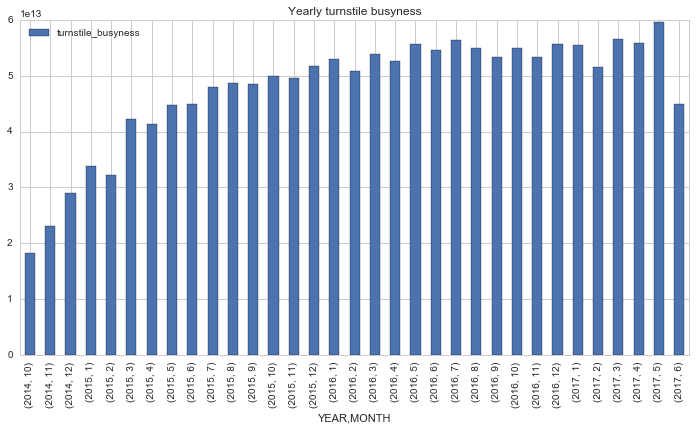

In [36]:
# plot yearly data for the last 3 years
turnstile_yearly.plot(kind = 'bar', figsize = (12,6), title = 'Yearly turnstile busyness')

### When are turstiles least active in the last year?

If we look at the data from the last 3 years on a monthly basis, turnstile busyness has increased, but there are certainly also dips in the trend. 

In terms of least activity in the last year,  we can see that Path WTC has the least turnstyle busyness actvitiy, and February was the least busyest month. While June has the least turnstile business, the data collected is not quite complete for June, so we should look at the following month with smallest number of exits and entries. 

In looking at the stations with turnstile busyness falling in the bottom 5%, we can see that there has been decreasing activity everywhere. These stations have had decreased turnstile entries and exists. In particular, the station with the highest decrease in activty in 2017 was Spring street, followed by other stations that also showed a percentage decrease in usage. 
Also, there are many stations not operating to full capacity such as:
WENTY THIRD ST, PATH WTC, 14TH STREET, FLUSHING AV, NEWARK HM HE,LACKAWANNA,47-50 STS ROCK,CANARSIE-ROCKAW (which showed up several times as having low turnstile activity, and ROOSEVELT ISLND.
Furthermore, I sampled a few stations and produced plots of yearly trends by station and noticed that there are many stations that are not used to capacity in comparison with other more popular ones. 
In terms of least busyest days, there are many days in January which were the least busy, but the day that had the fewest entries and exists was in March.

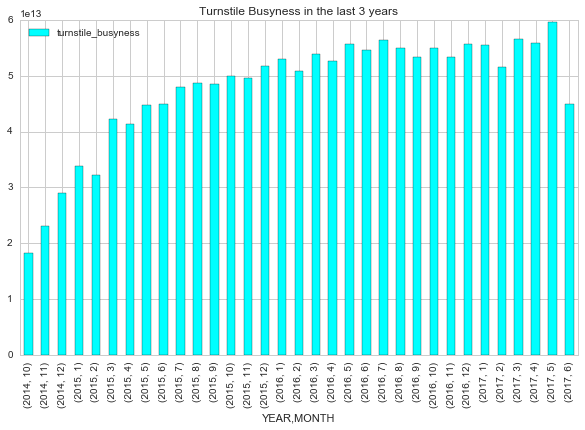

In [37]:
# in looking at the last 3 years turnstile busyness has been pretty consistent
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
pd.DataFrame(new_data.groupby(['YEAR','MONTH'])['turnstile_busyness'].sum()).plot(kind = 'bar', cmap='cool', ax=ax,
title='Turnstile Busyness in the last 3 years')
plt.show()

In [38]:
# 2017 data only
dat2017 = new_data[new_data.YEAR ==2017]

In [39]:
dat2017.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,turnstile_busyness,MONTH,YEAR
22165214,A002,R051,02-00-00,59 ST,NQR456W,2017-01-01,03:00:00,REGULAR,5992718.0,2028585.0,8021303.0,1,2017
22165215,A002,R051,02-00-00,59 ST,NQR456W,2017-01-01,07:00:00,REGULAR,5992730.0,2028594.0,8021324.0,1,2017
22165216,A002,R051,02-00-00,59 ST,NQR456W,2017-01-01,11:00:00,REGULAR,5992776.0,2028636.0,8021412.0,1,2017
22165217,A002,R051,02-00-00,59 ST,NQR456W,2017-01-01,15:00:00,REGULAR,5992980.0,2028680.0,8021660.0,1,2017
22165218,A002,R051,02-00-00,59 ST,NQR456W,2017-01-01,19:00:00,REGULAR,5993301.0,2028728.0,8022029.0,1,2017


In [40]:
# add weekly period
dat2017['WEEK'] = dat2017.DATE.dt.to_period('W')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


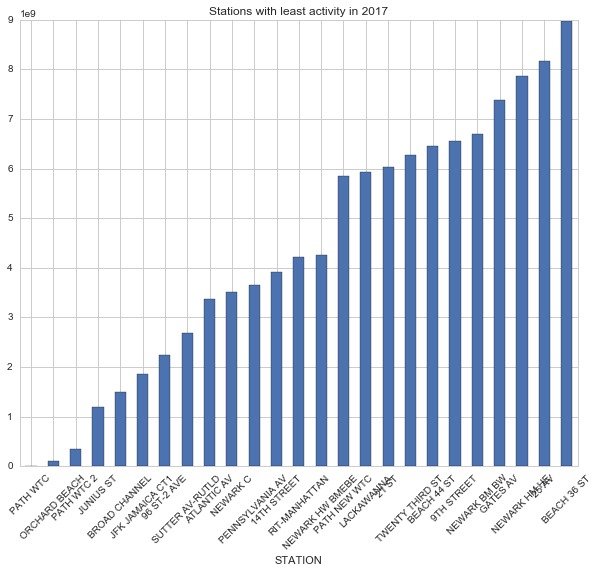

In [41]:
# we can see that path WTC has the least turnstile activity  
fig, ax = plt.subplots(figsize = (10,8))
dat2017.groupby(['STATION']).turnstile_busyness.sum().nsmallest(25).plot(kind = 'bar',ax=ax)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 45)
ax.set_title('Stations with least activity in 2017')

In [42]:
# what stations have less than 5% of overall turnstile busyness activity?
low_q = dat2017.turnstile_busyness.quantile(.05)

# when are turnstile the least busy?
noactivity = dat2017[dat2017.turnstile_busyness<low_q]

In [53]:
# group data with least activity by station and month
month_dat = noactivity.groupby(['STATION','WEEK']).turnstile_busyness.sum().reset_index()

In [60]:
# monthly activity by station
month_dat.sort_values('turnstile_busyness' , ascending=True, inplace=True)

In [61]:
# it looks like there are many stations not operating to full capacity
month_dat.head(15)

,STATION,WEEK,turnstile_busyness
3155,TWENTY THIRD ST,2017-03-20/2017-03-26,0.0
2708,PATH WTC,2017-05-15/2017-05-21,2.0
128,14TH STREET,2017-06-05/2017-06-11,3.0
1821,FLUSHING AV,2017-06-19/2017-06-25,18.0
2562,NEWARK HM HE,2017-01-23/2017-01-29,18.0
2301,LACKAWANNA,2017-05-22/2017-05-28,44.0
530,47-50 STS ROCK,2017-06-05/2017-06-11,50.0
1401,CANARSIE-ROCKAW,2017-05-08/2017-05-14,50.0
2849,ROOSEVELT ISLND,2016-12-26/2017-01-01,84.0
1404,CANARSIE-ROCKAW,2017-05-29/2017-06-04,84.0


In [56]:
station_dat = noactivity.groupby(['STATION', 'MONTH']).turnstile_busyness.sum()

In [62]:
# calculate percent changes
pct_changes = station_dat.pct_change().reset_index()
# remove missing values
pct_changes = pct_changes.dropna()

In [64]:
pct_changes.sort_values('turnstile_busyness').head()

,STATION,MONTH,turnstile_busyness
807,TWENTY THIRD ST,3,-1.000000
693,PATH WTC,5,-0.999840
452,FLUSHING AV,6,-0.999538
347,CANARSIE-ROCKAW,5,-0.999101
648,NEWARK C,4,-0.996623


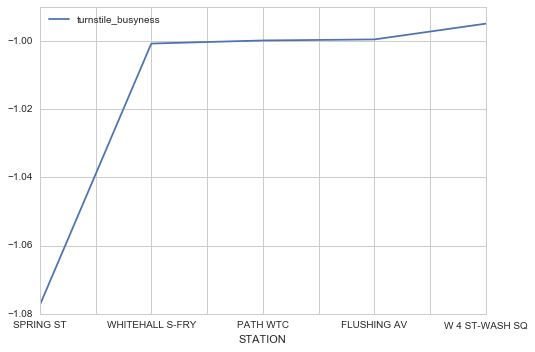

In [65]:
# we can see the stations with largest decrease in turnstile busyness
pct_changes.groupby('STATION').turnstile_busyness.sum().nsmallest(5).reset_index().plot(x='STATION', y = 'turnstile_busyness')

In [66]:
pct_changes_totals = pct_changes.groupby('STATION').turnstile_busyness.sum().reset_index()

In [67]:
# sample some stations with lowest activity and plot their trends to see fluctuations
sample_stations = pct_changes_totals.sort_values('turnstile_busyness',ascending = True).STATION.iloc[0:10].values.tolist()

In [68]:
sample_stations

[u'SPRING ST',
 u'WHITEHALL S-FRY',
 u'PATH WTC',
 u'FLUSHING AV',
 u'W 4 ST-WASH SQ',
 u'SUTTER AV',
 u'CRESCENT ST',
 u'GRAND-NEWTOWN',
 u'45 ST',
 u'ROCKAWAY PARK B']

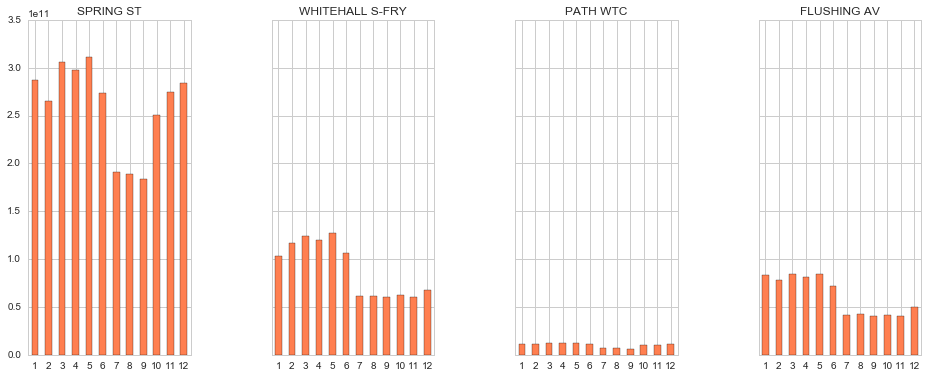

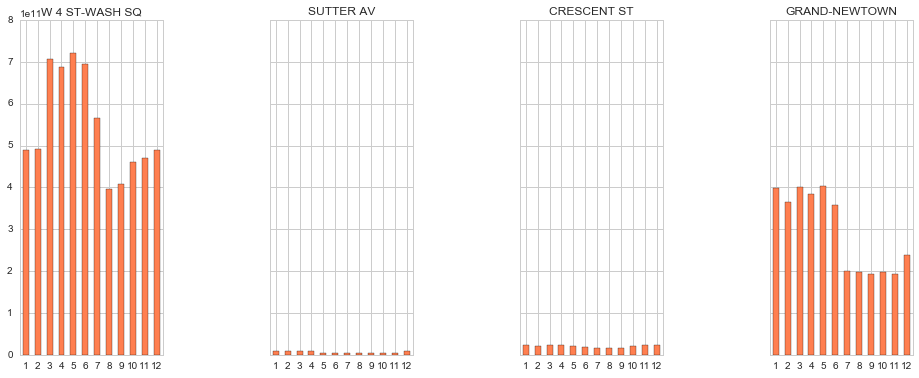

In [70]:
fig, axes = plt.subplots(nrows =1, ncols=4, figsize = (16,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=.8, wspace=.5)
for idx, s in enumerate(sample_stations[0:4]):
    station_dat = new_data[new_data.STATION ==s].groupby(['MONTH'])
    station_dat = station_dat['turnstile_busyness'].sum()
    plt_s = station_dat.plot(kind = 'bar', subplots=False, stacked = True, legend=None, color ='coral',
                             title = s, ax = axes[idx] )

    labels = [item.get_text() for item in axes[idx].get_xticklabels()]
    axes[idx].set_xticklabels(labels, rotation = 0)
    axes[idx].set_xlabel("")
plt.show()

fig, axes = plt.subplots(nrows =1, ncols=4, figsize = (16,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=.8, wspace=.75)
for idx, s in enumerate(sample_stations[4:8]):
    station_dat = new_data[new_data.STATION ==s].groupby(['MONTH'])
    station_dat = station_dat['turnstile_busyness'].sum()
    plt_s = station_dat.plot(kind = 'bar', subplots=False, stacked = True, legend=None, color ='coral',
                             title = s , ax = axes[idx] )

    labels = [item.get_text() for item in axes[idx].get_xticklabels()]
    axes[idx].set_xticklabels(labels, rotation = 0)
    axes[idx].set_xlabel("")
plt.show()

## 3) Linear Regression Model

For predicting the number of exits, I used linear regression. I used a training set of 90% and 10% test, and the linear model performed quite well, scoring 90%. 

In [74]:
smaller_data = new_data.copy()

In [75]:
smaller_data.YEAR.drop_duplicates()

0           2014
1868551     2015
11897434    2016
22165214    2017
Name: YEAR, dtype: int64

In [76]:
smaller_data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,turnstile_busyness,MONTH,YEAR
0,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,01:00:00,REGULAR,805439.0,1141080.0,1946519.0,10,2014
1,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,05:00:00,REGULAR,805459.0,1141141.0,1946600.0,10,2014
2,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,09:00:00,REGULAR,805589.0,1141257.0,1946846.0,10,2014
3,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,13:00:00,REGULAR,805834.0,1141512.0,1947346.0,10,2014
4,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,17:00:00,REGULAR,806150.0,1141903.0,1948053.0,10,2014


In [77]:
# we can see that there s a large differnce in exits 
print "standard deviation" , smaller_data.EXITS.std()
print "variance" , smaller_data.EXITS.var()

standard deviation 167360057.073
variance 2.80093887036e+16


In [78]:
# remove outliers in 5% and 95% quantiles
smaller_data = smaller_data[smaller_data.EXITS < smaller_data.EXITS.quantile(.95)]
smaller_data = smaller_data[smaller_data.EXITS > smaller_data.EXITS.quantile(.05)]
smaller_data = smaller_data[smaller_data.ENTRIES < smaller_data.ENTRIES.quantile(.95)]
smaller_data = smaller_data[smaller_data.ENTRIES > smaller_data.ENTRIES.quantile(.05)]
smaller_data.describe()

,ENTRIES,EXITS,turnstile_busyness,MONTH,YEAR
count,2.205366e+07,2.205366e+07,2.205366e+07,2.205366e+07,2.205366e+07
mean,3.465465e+06,2.746889e+06,6.212354e+06,6.299352e+00,2.015651e+03
std,3.354473e+06,3.160333e+06,5.850202e+06,3.565592e+00,8.574729e-01
min,5.064000e+03,7.300000e+01,5.164000e+03,1.000000e+00,2.014000e+03
25%,7.291550e+05,4.350010e+05,1.426559e+06,3.000000e+00,2.015000e+03
50%,2.407230e+06,1.532322e+06,4.451706e+06,6.000000e+00,2.016000e+03
75%,5.231680e+06,3.988440e+06,9.478791e+06,1.000000e+01,2.016000e+03
max,1.464520e+07,1.682097e+07,3.130366e+07,1.200000e+01,2.017000e+03


In [79]:
# group by turnstile and station for model
model_data = smaller_data.groupby(['UNIT','STATION','LINENAME'])[['ENTRIES','EXITS']].sum().reset_index()

In [80]:
model_data.head()

,UNIT,STATION,LINENAME,ENTRIES,EXITS
0,R001,SOUTH FERRY,1R,1.497829e+11,1.308987e+11
1,R001,SOUTH FERRY,1RW,5.417442e+10,4.906501e+10
2,R001,WHITEHALL S-FRY,R1,2.766132e+10,2.399062e+10
3,R001,WHITEHALL S-FRY,R1W,2.571050e+10,2.291517e+10
4,R001,WHITEHALL ST,R1,2.936655e+10,2.382652e+10


In [81]:
le = LabelEncoder()

# find categorical columns to encode
to_encode = model_data.select_dtypes(include = ['object','category']).columns

# make sure columns are strings
model_data[to_encode] = model_data[to_encode].astype(str)


In [82]:
# change features from categorical to numerically encoded 
for col in to_encode:
    print "encoded: ", col
    model_data[col] = le.fit_transform(model_data[col])

encoded:  UNIT
encoded:  STATION
encoded:  LINENAME


In [83]:
# assign predictors and response
X = model_data.drop(['EXITS'],axis=1)
y = model_data.EXITS

# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(scale(X), y, test_size=0.10, random_state=1)

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [92]:
lm = LinearRegression()
# fit linear regression model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
print "Linear Regression Model Score on test set",  lm.score(X_test, y_test)

Linear Regression Model Score on test set 0.903015614972


In [151]:
# remove outliers over 95% and less than 5%
data = data[data.EXITS < data.EXITS.quantile(.95)]
data = data[data.EXITS > data.EXITS.quantile(.05)]
data = data[data.ENTRIES < data.ENTRIES.quantile(.95)]
data = data[data.ENTRIES > data.ENTRIES.quantile(.05)]

In [153]:
data.head()

,ControlArea,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,turnstile_busyness,MONTH,YEAR
0,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,01:00:00,REGULAR,805439.0,1141080.0,1946519.0,10,2014
1,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,05:00:00,REGULAR,805459.0,1141141.0,1946600.0,10,2014
2,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,09:00:00,REGULAR,805589.0,1141257.0,1946846.0,10,2014
3,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,13:00:00,REGULAR,805834.0,1141512.0,1947346.0,10,2014
4,A060,R001,00-00-00,WHITEHALL ST,R1,2014-10-11,17:00:00,REGULAR,806150.0,1141903.0,1948053.0,10,2014


In [154]:
le = LabelEncoder()

# find categorical columns to encode
to_encode = data.select_dtypes(include = ['object','category']).columns

# make sure columns are strings
data[to_encode] = data[to_encode].astype(str)


In [157]:
to_encode

Index([u'ControlArea', u'UNIT', u'SCP', u'STATION', u'LINENAME', u'TIME',
       u'DESC'],
      dtype='object')

In [ ]:
# change features from categorical to numerically encoded 
for col in to_encode:
    print "encoded: ", col
    data[col] = le.fit_transform(data[col])

encoded:  ControlArea
encoded:  UNIT
encoded:  SCP
encoded:  STATION


In [ ]:
larger_data = data.groupby(['UNIT','STATION','LINENAME'])[['ENTRIES','EXITS']].sum().reset_index()

In [ ]:
# assign predictors and response
X = larger_data.drop(['EXITS'],axis=1)
y = larger_data.EXITS

# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(scale(X), y, test_size=0.10, random_state=1)

In [ ]:
lm = LinearRegression()
# fit linear regression model
lm.fit(X_train, y_train)

In [ ]:
print "Linear Regression Model Score on test set",  lm.score(X_test, y_test)